Original shape: (101219, 18)

Columns:
 ['URL', 'url_length', 'has_ip_address', 'dot_count', 'https_flag', 'url_entropy', 'token_count', 'subdomain_count', 'query_param_count', 'tld_length', 'path_length', 'has_hyphen_in_domain', 'number_of_digits', 'tld_popularity', 'suspicious_file_extension', 'domain_name_length', 'percentage_numeric_chars', 'ClassLabel']

Cleaned Data Sample:

                                               URL  ClassLabel
0  https://keraekken-loagginnusa.godaddysites.com/           1
1         https://metamsk01lgiix.godaddysites.com/           1
2                          http://myglobaltech.in/           1
3                   http://djtool-for-spotify.com/           1
4  https://scearmcoommunnlty.com/invent/freind/get           1

Missing values:

URL           0
ClassLabel    0
dtype: int64

Class Distribution:
ClassLabel
1    63678
0    37540
Name: count, dtype: int64

Class Distribution (%):
ClassLabel
1    62.91
0    37.09
Name: proportion, dtype: float64


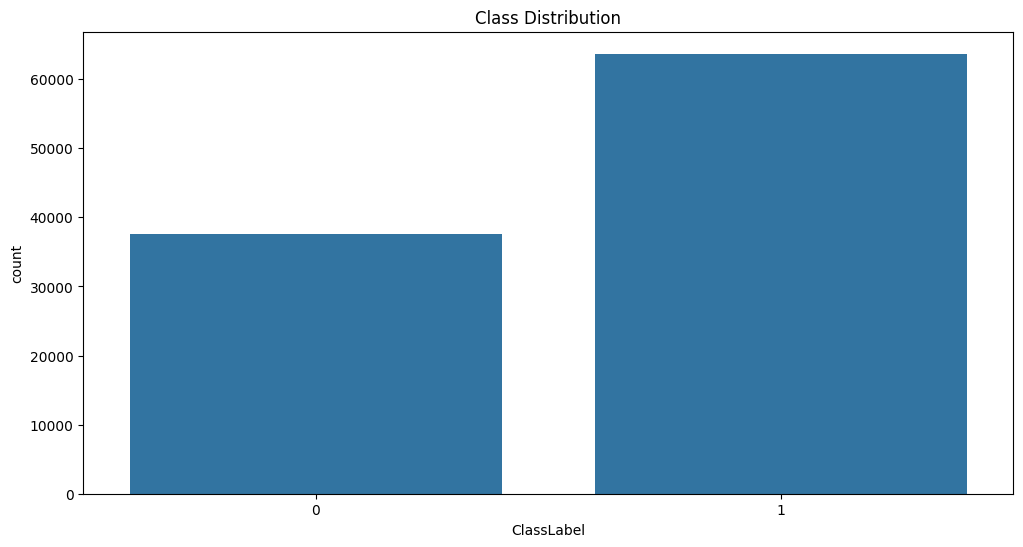

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import re
from urllib.parse import urlparse

# ML libs
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC


# EDA
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("url.csv")

print("Original shape:", df.shape)
print("\nColumns:\n", df.columns.tolist())

# Keep only URL + label
df = df[["URL", "ClassLabel"]].dropna()
# Flip labels if dataset uses opposite convention
df["ClassLabel"] = df["ClassLabel"].apply(lambda x: 1 if x == 0 else 0) 
df.reset_index(drop=True, inplace=True)

print("\nCleaned Data Sample:\n")
print(df.head())

#Eda
print("\nMissing values:\n")
print(df.isnull().sum())

print("\nClass Distribution:")
print(df["ClassLabel"].value_counts())
print("\nClass Distribution (%):")
print((df["ClassLabel"].value_counts(normalize=True)*100).round(2))

#EDA
plt.figure(figsize=(12,6))
sns.countplot(data=df, x="ClassLabel")
plt.title("Class Distribution")
plt.show()




Extracting features with updated extractor...



Processing URLs: 100%|██████████| 101218/101218 [00:02<00:00, 44182.16it/s]



New feature dataset shape: (101218, 20)
   url_length  has_ip_address  dot_count  https_flag  url_entropy  \
0          47               0          2           1     0.468085   
1          40               0          2           1     0.525000   
2          23               0          1           0     0.739130   
3          30               0          1           0     0.600000   
4          47               0          1           1     0.468085   

   token_count  subdomain_count  query_param_count  tld_length  path_length  \
0            3                2                  0           3            1   
1            3                2                  0           3            1   
2            3                1                  0           2            1   
3            3                1                  0           3            1   
4            5                1                  0           3           18   

   has_hyphen_in_domain  number_of_digits  tld_popularity  \
0       

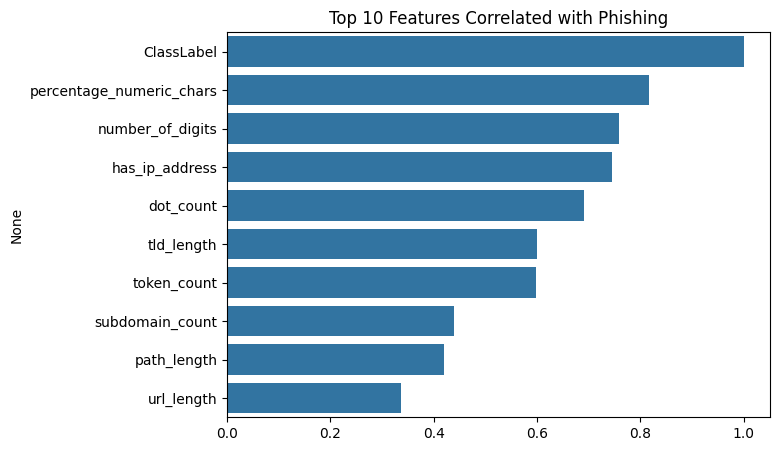

In [31]:
#Feature Engineering
from urllib.parse import urlparse
import re

# keywords commonly used in phishing
PHISH_KEYWORDS = [
    "login", "logon", "signin", "verify", "verification", "update",
    "secure", "security", "account", "password", "bank", "payment",
    "confirm", "webscr", "billing", "credential"
]

BRAND_KEYWORDS = [
    "paypal", "apple", "google", "amazon", "microsoft", "netflix", "bank",
    "hdfc", "sbi", "icici", "facebook", "instagram"
]

def extract_features(url: str) -> dict:
    parsed = urlparse(url)
    domain = parsed.netloc
    path = parsed.path
    query = parsed.query
    full = url.lower()
    
    # tld
    tld = domain.split(".")[-1] if "." in domain else ""
    
    suspicious_ext = (".html", ".htm", ".php", ".asp", ".aspx", ".exe", ".apk", ".zip")
    
    tld_pop_map = {
        "com": 100, "org": 90, "net": 85, "edu": 80, "gov": 75,
        "co": 70, "in": 65, "io": 60, "info": 30, "xyz": 20,
    }
    
    url_len = len(url)
    digits_count = sum(c.isdigit() for c in url)
    
    # keyword features
    keyword_count = sum(full.count(k) for k in PHISH_KEYWORDS)
    has_suspicious_keyword = int(any(k in full for k in PHISH_KEYWORDS))
    brand_word_flag = int(any(b in full for b in BRAND_KEYWORDS))
    
    features = {
        "url_length": url_len,
        "has_ip_address": int(bool(re.match(r"(\d{1,3}\.){3}\d{1,3}", domain))),
        "dot_count": url.count("."),
        "https_flag": int(parsed.scheme == "https"),
        "url_entropy": (len(set(url)) / url_len) if url_len else 0,
        "token_count": url.count("/") + url.count("?") + url.count("&") + url.count("="),
        "subdomain_count": domain.count("."),
        "query_param_count": query.count("&") + query.count("="),
        "tld_length": len(tld),
        "path_length": len(path),
        "has_hyphen_in_domain": int("-" in domain),
        "number_of_digits": digits_count,
        "tld_popularity": tld_pop_map.get(tld, 10),
        "suspicious_file_extension": int(path.endswith(suspicious_ext)),
        "domain_name_length": len(domain),
        "percentage_numeric_chars": (digits_count / url_len * 100) if url_len else 0,
        
        # NEW FEATURES
        "keyword_count": keyword_count,
        "has_suspicious_keyword": has_suspicious_keyword,
        "has_brand_keyword": brand_word_flag,
    }
    
    return features

from tqdm import tqdm

feature_rows = []

print("\nExtracting features with updated extractor...\n")
for url in tqdm(df["URL"], desc="Processing URLs"):
    feature_rows.append(extract_features(url))

features_df = pd.DataFrame(feature_rows)
features_df["ClassLabel"] = df["ClassLabel"]

print("\nNew feature dataset shape:", features_df.shape)
print(features_df.head())


#Correlation
corr = features_df.corr(numeric_only=True)["ClassLabel"].sort_values(ascending=False)

print("\n🔍 Feature Correlation with Phishing Label:\n")
print(corr.head(15))

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
sns.barplot(x=corr.head(10).values, y=corr.head(10).index)
plt.title("Top 10 Features Correlated with Phishing")
plt.show()




In [32]:
X = features_df.drop("ClassLabel", axis=1)
y = features_df["ClassLabel"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.35, random_state=42, stratify=y
)

models = {
    "Logistic Regression": LogisticRegression(max_iter=1500),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "Linear SVM": LinearSVC(),
    "Naive Bayes": GaussianNB()
}

results = []

for name, model in models.items():
    print(f"\nTraining: {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    results.append([
        name,
        round(accuracy_score(y_test, y_pred), 4),
        round(precision_score(y_test, y_pred), 4),
        round(recall_score(y_test, y_pred), 4),
        round(f1_score(y_test, y_pred), 4)
    ])

results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score"])

print("\n📊 Model Comparison:\n")
print(results_df.sort_values("F1 Score", ascending=False))



Training: Logistic Regression...

Training: Random Forest...

Training: Linear SVM...

Training: Naive Bayes...

📊 Model Comparison:

                 Model  Accuracy  Precision  Recall  F1 Score
1        Random Forest    0.9996     0.9995  0.9999    0.9997
0  Logistic Regression    0.9970     0.9990  0.9962    0.9976
2           Linear SVM    0.9963     0.9980  0.9961    0.9970
3          Naive Bayes    0.9879     0.9882  0.9926    0.9904


In [39]:
best_row = results_df.sort_values("F1 Score", ascending=False).iloc[0]
best_model_name = best_row["Model"]
best_model = models[best_model_name]

print("\n🏆 Best Model:", best_model_name)

training_features = list(X.columns)

def predict_url(url: str) -> str:
    feats = extract_features(url)
    feat_df = pd.DataFrame([feats])

    # ensure all columns present
    for col in training_features:
        if col not in feat_df.columns:
            feat_df[col] = 0

    feat_df = feat_df[training_features]

    pred = best_model.predict(feat_df)[0]
    return "⚠️ Phishing Website" if pred == 1 else "✔️ Legitimate Website"
# print(predict_url("https://github.com/"))
# print(predict_url("https://google.com/"))
# print(predict_url("http://paypal-update-login-secure.com"))
# print(predict_url("http://secure-banking-verification-alert.net"))
# print(predict_url("https://lpu.in"))
# print(predict_url("https://aistudio.google.cxcmlscmksldom/apps"))
print(predict_url("https://github.com/"))



🏆 Best Model: Random Forest
✔️ Legitimate Website


In [37]:
import joblib

# Save the best trained model
joblib.dump(best_model, "best_model.joblib")

# Save training column order
joblib.dump(training_features, "training_columns.joblib")   

print("✅ Model and training columns saved successfully")


✅ Model and training columns saved successfully
